<a href="https://colab.research.google.com/github/JacobJ215/YOLO-NAS-SAM/blob/main/YOLO_NAS%2BSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object Detection & Image Segmentation using YOLO-NAS + SAM

### Install required packages

In [1]:
!pip install ultralytics install super-gradients -q
!pip install git+https://github.com/facebookresearch/segment-anything.git -q
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.6 MB/s eta 0:00:

### Import required libraries

In [ ]:
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from super_gradients.training import models


### Detections with YOLO-NAS

In [ ]:
image_path = '/content/restaurant_1.png'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model = models.get('yolo_nas_l', pretrained_weights="coco")
model.predict(image, conf=0.25).show()

conf_threshold = 0.25
detection_pred = model.predict(image_path, conf=conf_threshold)
detections = detection_pred.save('output_folder')

In [ ]:
# Extract bounding boxes, confidence scores, and labels
detection_pred = model.predict(image_path, conf=conf_threshold)._images_prediction_lst

bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
confidence = detection_pred[0].prediction.confidence.tolist()
labels = detection_pred[0].prediction.labels.tolist()

### Add helper functions for SAM

In [ ]:
# Helper functions - https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=365):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', maker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
# SAM Model for masking
sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

In [ ]:
# Load Class Names from COCO dataset
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
          "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
          "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
          "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
          "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
          "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
          "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
          "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
          "teddy bear", "hair drier", "toothbrush"
        ]

In [ ]:
# Create a predictor for SAM
image = cv2.imread(image_path)
predictor = SamPredictor(sam)
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

### Display prediction

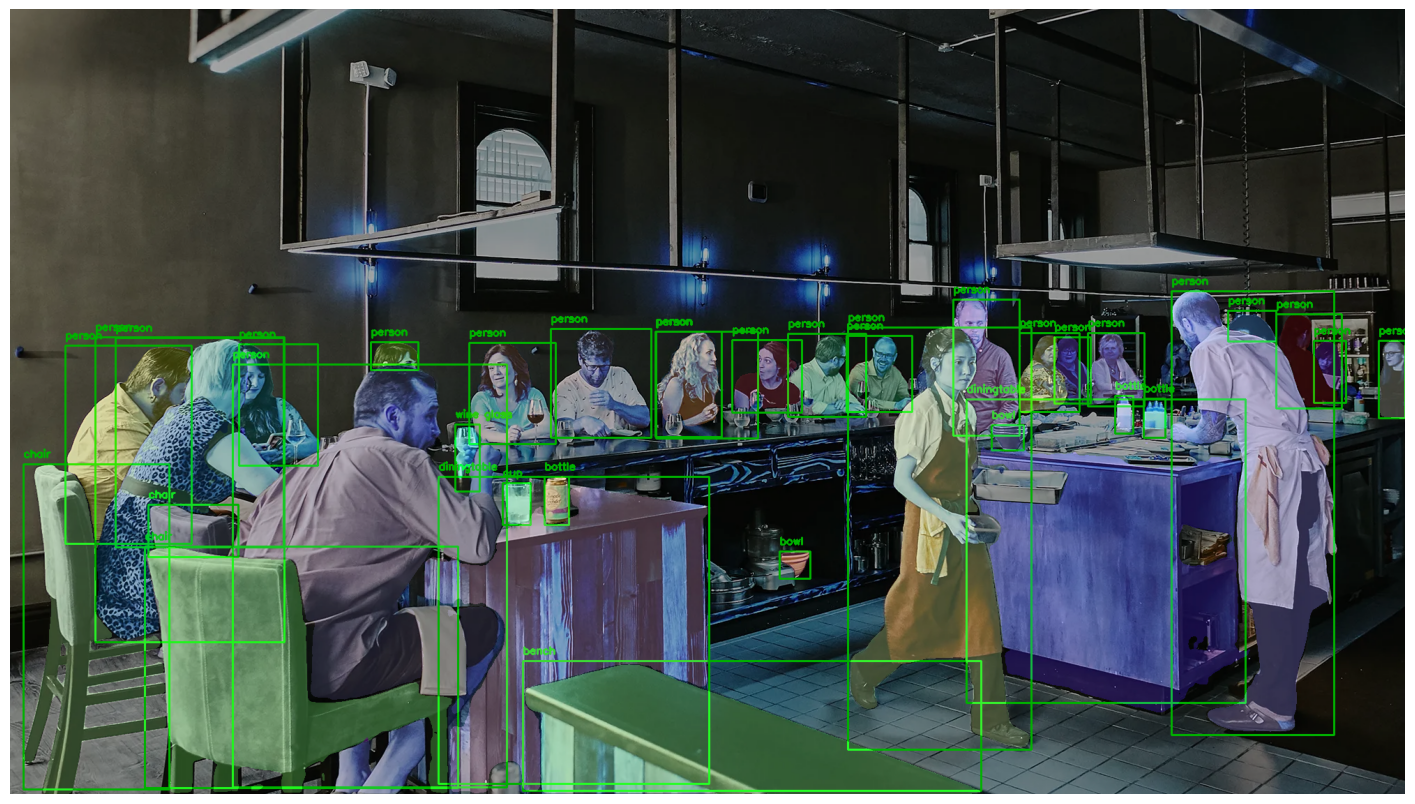

In [9]:
# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes_xyxy[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# Display the image
plt.figure(figsize=(18, 18))
plt.imshow(final_image)
plt.axis('off')
plt.savefig('output_folder/prediction.png')  # Save the combined output
plt.show()
